In [0]:
# Code to install pytorch on virtual machine (COLAB specific)

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# Code to install (Python Image Library) (PIL) library (specific version)
!pip uninstall Pillow
!pip install Pillow==5.3.0

In [0]:
# All necessary import
import os        # For creating a directory
import torch     # core torch library
import torch.nn as nn  # pytorch nn module 
import torch.nn.functional as F  
from torch.autograd import Variable

import torchvision  
from torchvision import datasets  # to download dataset
from torchvision import transforms  # to perform transformations on dataset 
from torchvision.utils import save_image # to save image

from IPython.display import Image # to display image

In [0]:
bs = 128 # batch size
epochs = 10 # total epochs

In [0]:
# Function to convert a input to Variable
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:
# Flatten the input data
def flatten(x):
    return to_var(x.view(x.size(0), -1))

In [0]:
# Function to save image
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [0]:
# Load Data and Convert it to tensor
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
# Create a data loader object
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [33]:
# Create an object of VAE class
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [0]:
# Initialize the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
# Define the loss function
def loss_fn(recon_x, x, mu, logvar):
    # Binary cross entropy loss
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [0]:
# Total number of epochs
epochs = 10

In [0]:
# Create a directory if not exists
sample_dir = 'reconstructed'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

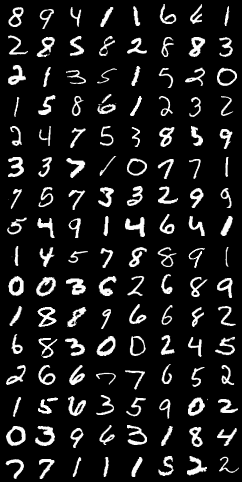

In [38]:
# Fixed input for debugging while training
fixed_x, _ = next(iter(data_loader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)

Image('real_image.png')

In [57]:
for epoch in range(epochs): # Train for #epochs  
    for idx, (images, _) in enumerate(data_loader): #iterate over whole batch
        images = flatten(images)    # flatten the image
        recon_images, mu, logvar = vae(images)  # forward pass
        loss = loss_fn(recon_images, images, mu, logvar) # Compute loss

        optimizer.zero_grad()   # Initialize all gradients to zero
        loss.backward()         # backward pass
        optimizer.step()        # Update weights
        
        if idx%100 == 0:        
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data[0]/bs))
            
            # Reconstruct image for the fixed_x and store
            recon_x, _, _ = vae(fixed_x)
            save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'recon_image_{epoch}_{idx}.png')\
          

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Epoch[1/10] Loss: 103.995
Epoch[1/10] Loss: 105.998
Epoch[1/10] Loss: 105.461
Epoch[1/10] Loss: 104.968
Epoch[1/10] Loss: 102.781
Epoch[2/10] Loss: 107.208
Epoch[2/10] Loss: 104.134
Epoch[2/10] Loss: 107.210
Epoch[2/10] Loss: 103.717
Epoch[2/10] Loss: 104.391
Epoch[3/10] Loss: 107.780
Epoch[3/10] Loss: 104.154
Epoch[3/10] Loss: 102.371
Epoch[3/10] Loss: 104.269
Epoch[3/10] Loss: 107.632
Epoch[4/10] Loss: 100.224
Epoch[4/10] Loss: 105.512
Epoch[4/10] Loss: 103.824
Epoch[4/10] Loss: 108.295
Epoch[4/10] Loss: 107.913
Epoch[5/10] Loss: 102.427
Epoch[5/10] Loss: 106.678
Epoch[5/10] Loss: 106.553
Epoch[5/10] Loss: 104.394
Epoch[5/10] Loss: 104.364
Epoch[6/10] Loss: 103.972
Epoch[6/10] Loss: 101.107
Epoch[6/10] Loss: 104.324
Epoch[6/10] Loss: 103.485
Epoch[6/10] Loss: 103.788
Epoch[7/10] Loss: 105.272
Epoch[7/10] Loss: 104.534
Epoch[7/10] Loss: 107.093
Epoch[7/10] Loss: 106.253
Epoch[7/10] Loss: 102.815
Epoch[8/10] Loss: 103.614
Epoch[8/10] Loss: 106.118
Epoch[8/10] Loss: 105.494
Epoch[8/10] 

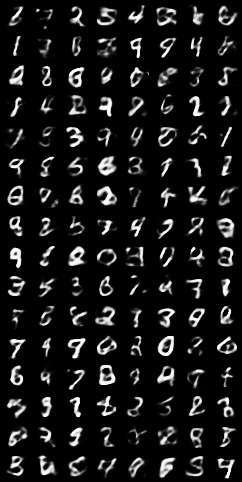

In [61]:
# Generate from random noise
sample = Variable(torch.randn(128, 20))
recon_x = vae.decoder(sample) # Decoder 
#recon_x, _, _ = vae(fixed_x)

save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), 'sample_image.png')
Image('sample_image.png')